In [1]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from model_settings import ms
from plotters import PlotCols
import matplotlib.pyplot as plt

ms.find_root(Path())

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

# loading model

In [3]:
root = os.path.join(ms.root)
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if not f.startswith('.') and f.find('Legacy')])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024-11-09 112825652640 cboe spx relative asian
1     2024-11-09 124653897492 cboe spx relative barrier


In [4]:
selected_model = models.iloc[0]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

{'seed': 1312,
 'raw_data':         spot_price  strike_price  days_to_maturity  n_fixings  \
 0           1274.0        637.00                 7        1.0   
 1           1274.0        637.00                 7        1.0   
 2           1274.0        637.00                 7        1.0   
 3           1274.0        637.00                 7        1.0   
 4           1274.0        955.50                 7        1.0   
 ...            ...           ...               ...        ...   
 338935      5857.0       7320.75                84        1.0   
 338936      5857.0       8785.00                84        1.0   
 338937      5857.0       8785.00                84        1.0   
 338938      5857.0       8785.00                84        1.0   
 338939      5857.0       8785.00                84        1.0   
 
         fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                      7             0      geometric  call        0.001578   
 1                 

In [5]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [6]:
unretrained = model['model']

In [7]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     7
1    28
2    84
Name: days_to_maturity, dtype: int64

fixing frequency: 
0     7
1    28
2    84
Name: fixing_frequency, dtype: int64

past fixings: 
0    0
Name: past_fixings, dtype: int64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
781    0.054494
782    0.054500
783    0.054513
784    0.054801
785    0.054889
Name: risk_free_rate, Length: 786, dtype: float64

dividend rate: 
0       0.012624
1       0.012628
2       0.012641
3       0.012671
4       0.012687
          ...   
1152    0.023672
1153    0.023681
1154    0.023780
1155    0.023823
1156    0.024133
Name: dividend_rate, Length: 1157, dtype: float64

kappa: 
0       3.553361e-10
1       3.924365e-10
2       7.518568e-10
3       8.464905e-10
4       1.055398e-09
            ...     
1747    6.161121e+01
1748    6.214923e+01
1749    6.690466e+01
1750    8.814194e+01
1751    1.158504e+02
Name: kappa, Length: 1752, dtype: float64

th

In [8]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
print(model['feature_set'])
model['numerical_features']

['days_to_maturity', 'fixing_frequency', 'past_fixings', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'relative_spot', 'averaging_type', 'w']


['days_to_maturity',
 'fixing_frequency',
 'past_fixings',
 'risk_free_rate',
 'dividend_rate',
 'kappa',
 'theta',
 'rho',
 'eta',
 'v0',
 'relative_spot']

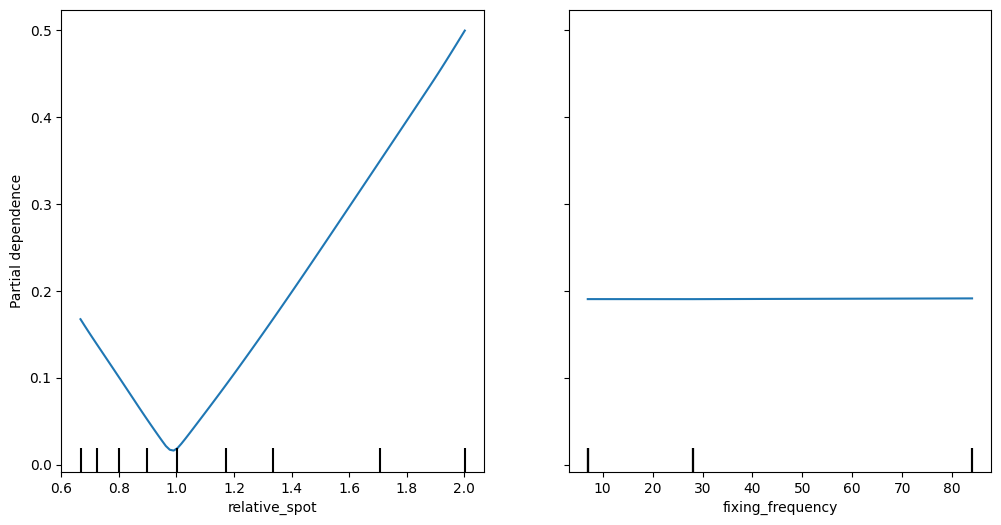

In [23]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

part_disp_X = train_data[unretrained.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
cols = [
    'relative_spot',
    'fixing_frequency',
    # 'relative_barrier',
    # 'kappa','theta','rho','eta',
    # 'v0',
    # 'risk_free_rate','dividend_rate'
]
disp = PartialDependenceDisplay.from_estimator(unretrained, part_disp_X, cols, ax=ax, n_cols=2)

In [10]:
# import joblib
# disp = joblib.load('relative_barrier_options_partial_display.pkl')
# help(disp.plot)

# retraining

In [11]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [12]:
test_dates = model['test_dates']
full_dataset = model['dataset']
pricename = [f[:f.find('_',0)] for f in full_dataset.columns if f.find('asian_price')!=-1 or f.find('barrier_price')!=-1][0]
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates = pd.to_datetime(all_dates,format='mixed')
# i = 0
# for date in all_dates:
#     i += 1
#     plt.scatter(date,i)

retraining_frequency = 20

n = model['test_dates'].shape[0]//retraining_frequency

In [13]:
cols = ['outofsample_MAE','outofsample_RMSE']
df = pd.DataFrame()

models = {}


for i in range(0,n):
    development_dates = pd.to_datetime(model['development_dates'],format='mixed')
    subset_test_dates = pd.to_datetime(model['test_dates'][(i*retraining_frequency):(i+1)*retraining_frequency],format='fixed')
    subset_test = full_dataset[full_dataset['date'].isin(subset_test_dates)]
    target = subset_test['relative_observed']
    prediction = unretrained.predict(subset_test[model['feature_set']])
    error = prediction-target
    date = subset_test_dates.iloc[0]
    df.at[date,'outofsample_MAE'] = compute_MAE(error)
    df.at[date,'outofsample_RMSE'] = compute_RMSE(error)
    df.at[date,'avgsqrtv0'] = np.mean(np.sqrt(subset_test['v0']))
    df.at[date,'avgspot'] = np.mean(subset_test['spot_price'])

df.index = pd.to_datetime(df.index)
df

,outofsample_MAE,outofsample_RMSE,avgsqrtv0,avgspot
2012-11-06,0.005963,0.009630,0.249055,1409.966667
2013-02-04,0.003528,0.005019,0.184722,1533.807692
2013-04-25,0.003267,0.004914,0.196642,1623.653846
2013-06-10,0.003656,0.005622,0.247043,1636.575758
2013-08-09,0.003320,0.004916,0.165528,1678.961538
...,...,...,...,...
2023-08-31,2.873988,2.904735,0.228525,4383.040000
2023-11-08,2.724340,2.755863,0.218752,4634.593750
2024-01-25,2.644957,2.671264,0.278784,5038.518519
2024-03-26,2.727722,2.756128,0.229676,5206.600000


['outofsample_MAE', 'outofsample_RMSE', 'avgsqrtv0', 'avgspot']


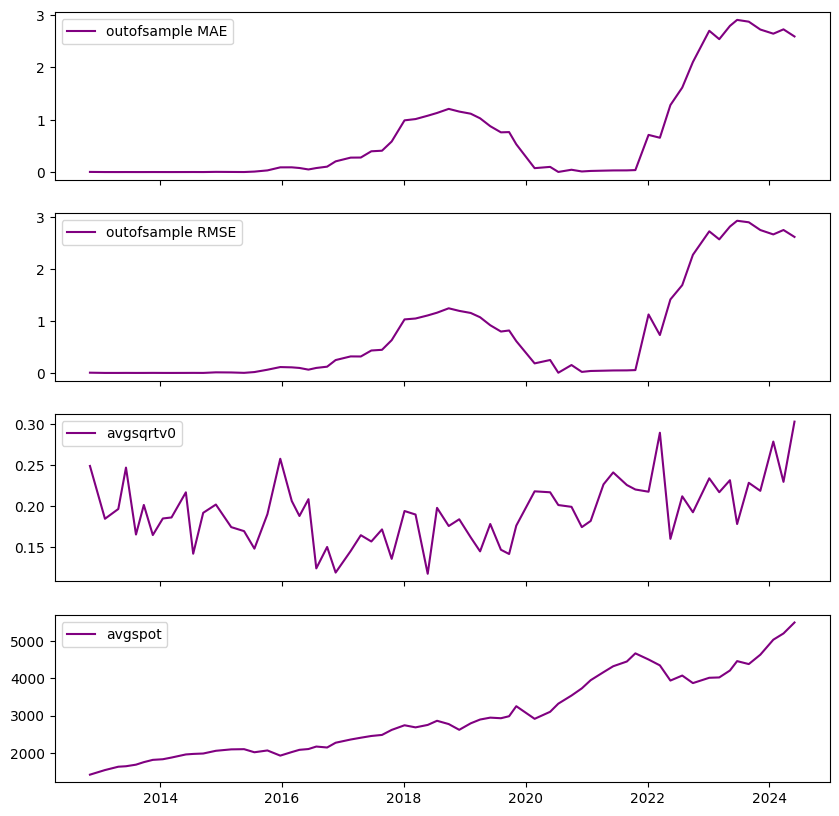

In [14]:
from plotters import PlotCols
PlotCols(df,figsize=(10,10))

In [15]:
test_data = model['test_data'].copy()

test_data['sqrtv0'] = np.sqrt(test_data['v0'])
sqrtv0 = test_data['sqrtv0']
quants = sqrtv0.describe()[3:]
quants

min    0.010116
25%    0.111623
50%    0.153286
75%    0.244846
max    0.780206
Name: sqrtv0, dtype: float64

In [16]:
quantiles = {}
for i in range(1,5):
    print(i)
    quantiles[quants.index[i]] = test_data[(test_data['sqrtv0']>quants.iloc[i-1])&(test_data['sqrtv0']<=quants.iloc[i])].copy()

1
2
3
4


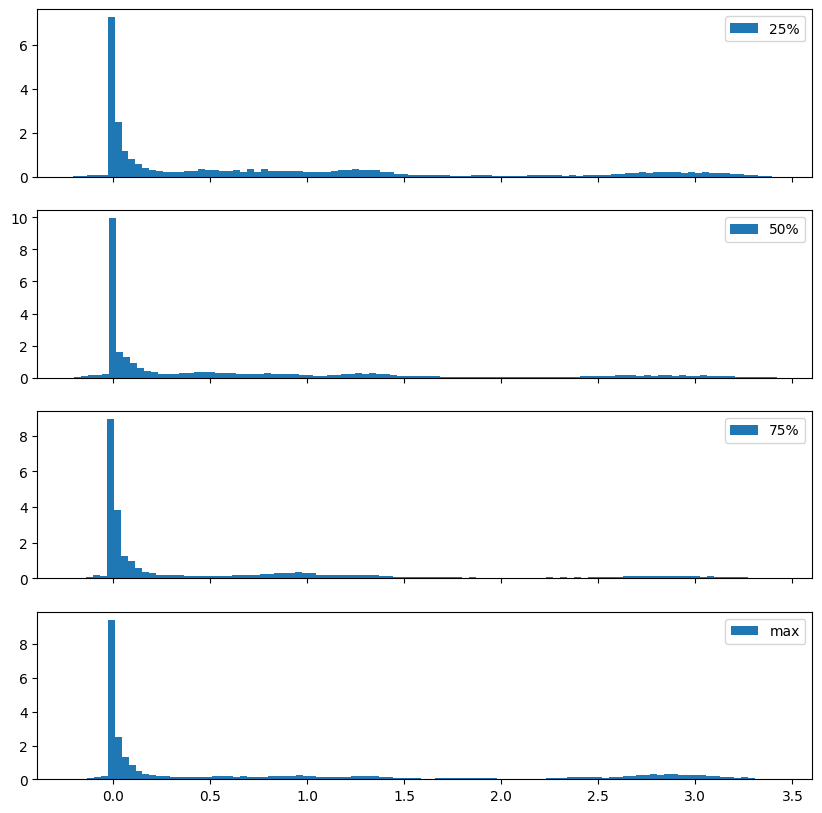

In [17]:
fig,axs = plt.subplots(4,sharex=True,figsize=(10,10))
i = 0
for q,d in quantiles.items():
    axs[i].hist(d['outofsample_error'],density=True,bins=100,label=q)
    axs[i].legend()
    i += 1

plt.show()

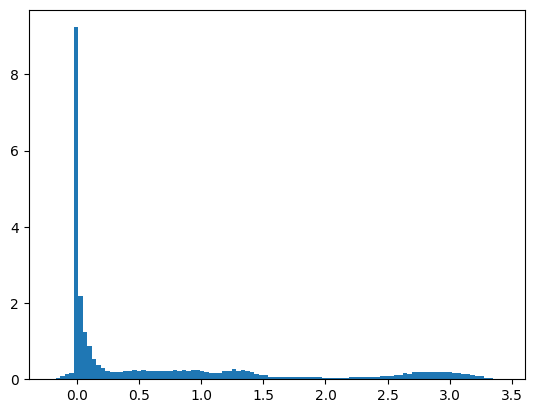

In [18]:
plt.figure()
plt.hist(test_data['outofsample_error'],bins=100,density=True)
plt.show()

In [19]:
train_data['v0'].describe()

count    23580.000000
mean         0.088573
std          0.109829
min          0.000188
25%          0.018266
50%          0.039313
75%          0.108155
max          0.493059
Name: v0, dtype: float64

In [20]:
test_data['v0'].describe()

count    315360.000000
mean          0.056290
std           0.083109
min           0.000102
25%           0.012460
50%           0.023497
75%           0.059950
max           0.608722
Name: v0, dtype: float64

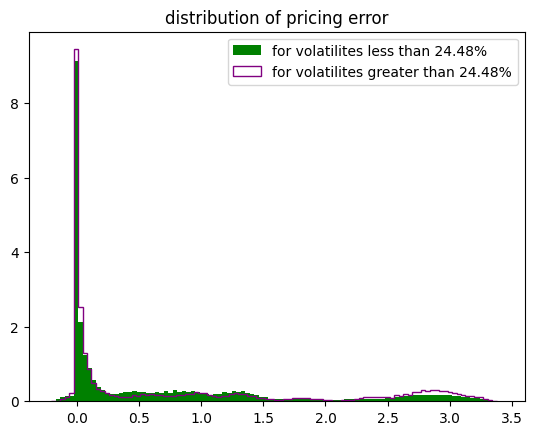

In [21]:
col = 'sqrtv0'
desc = test_data[col].describe()

p75 = desc['75%']
normal_vol = test_data[test_data['sqrtv0']<=p75]
high_vol = test_data[test_data['sqrtv0']>p75]

# fig,axs = plt.subplots(2,sharex=True)
# axs[0].hist(high_vol['outofsample_error'],density=True,bins=10,label=f'for volatilites greater than {round(100*p75,2)}%')
# axs[0].legend()
# axs[1].hist(low_vol['outofsample_error'],density=True,bins=10,label=f'for volatilites less than {round(100*p75,2)}%')
# axs[1].legend()
# plt.show()
bins = 100
plt.figure()
plt.title('distribution of pricing error')
plt.hist(normal_vol['outofsample_error'],density=True,bins=bins,label=f'for volatilites less than {round(100*p75,2)}%',color='green')
plt.hist(high_vol['outofsample_error'],density=True,bins=bins,label=f'for volatilites greater than {round(100*p75,2)}%',color='purple',histtype='step')


plt.legend()
plt.show()